# Visualizing steps of a CNN model :

The Dogs vs. Cats Dataset :
* Need to download data on Kaggle with an account
* 25000 grayscale images of A×A pixels each, with 2 classes

The VGG16 model :
* Included in Keras appliations
* Pre-trained on ImageSet dataset
* ImageSet is 1.4M labeled images with 1000 classes containing animals...

There are two ways to use a pre-trained network : 
* Feature Extraction -> Use the Convutional Base and changing the dense connected classifier
    * Predict features using the Convutional Base Network and then applying a own dense connected Classifier
    * Extending the  Convutional Base Network by adding own dense connected Classifier on top and running the whole thing end to end on input data. This allow to use data augmentation 
* Fine Tuning -> Tune the last Convutional Layers of pre-trained model

In [8]:
import tensorflow
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomZoom
import numpy as np
from tensorflow.keras.preprocessing import image_dataset_from_directory #utility to convert JPEG to RGB tensors
from tensorflow.keras.preprocessing import image
print(tensorflow.__version__)

2.4.0


In [2]:
import os, shutil, pathlib
original_dir = pathlib.Path("datasets/dogs_vs_cats/train")
print(original_dir)

datasets/dogs_vs_cats/train


In [3]:
new_base_dir = pathlib.Path("datasets/cats_vs_dogs_small")

try:
    #Create a subset folder of the entire image folder from Kaggle
    def make_subset(subset_name, start_index, end_index):
        for category in ("cat", "dog"):
            dir = new_base_dir / subset_name / category
            os.makedirs(dir)
            fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
            for fname in fnames:
                shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

    make_subset("train", start_index=0, end_index=1000)
    make_subset("validation", start_index=1000, end_index=1500)
    make_subset("test", start_index=1500, end_index=2500)
except:
    print("already created")

already created


# Data Preprocessing a single image :

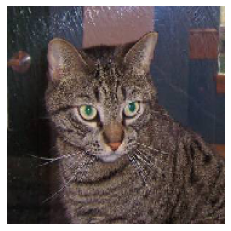

In [24]:
#Affichage de l'image
img_path = "datasets/cats_vs_dogs_small/train/cat/cat.1.jpg"

def get_img_array(img_path, target_size):
    img = image.load_img(
        img_path, target_size=target_size)
    array =image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

img_tensor = get_img_array(img_path, target_size=(180, 180))
plt.axis("off")
plt.imshow(img_tensor[0].astype("uint8"))
plt.show()

**Loading the old model CNN from scratch :**

In [25]:
model = keras.models.load_model("convnet_from_scratch.keras")
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 87, 87, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 43, 43, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 41, 41, 128)       73856 

2021-12-16 18:20:35.135881: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [26]:
layer_outputs = []
layer_names = []
for layer in model.layers:
    if isinstance(layer, (layers.Conv2D, layers.MaxPooling2D)):  #Extract the output of the top 8 layers
        layer_outputs.append(layer.output)
        layer_names.append(layer.name)

#Build a new Keras Multi-Output Model with custom input and outputs 
activation_model = keras.Model(inputs=model.input, outputs=layer_outputs) #The model returns these output given the model input

In [27]:
activation_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 87, 87, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 43, 43, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 41, 41, 128)       73856 

In [28]:
activations = activation_model.predict(img_tensor)

2021-12-16 18:25:02.260009: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


In [29]:
#This is the activation (=feature map, output of the layer) of the first conv layer for our image :
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 178, 178, 32)


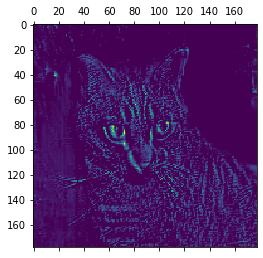

In [32]:
#Let's try plotting the 5th channel of the activation of the 1st layer :
plt.matshow(first_layer_activation[0, :, :, 5], cmap="viridis")

Note that this channel is encoding edges detector and eyes.

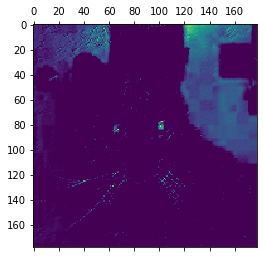

In [43]:
#Let's try plotting the 6th channel of the activation of the 1st layer :
plt.matshow(first_layer_activation[0, :, :, 6], cmap="viridis")

Now we will plot every channel in every intermediate activation : 

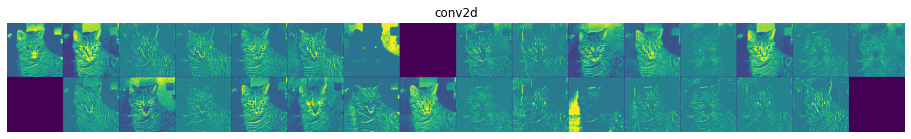

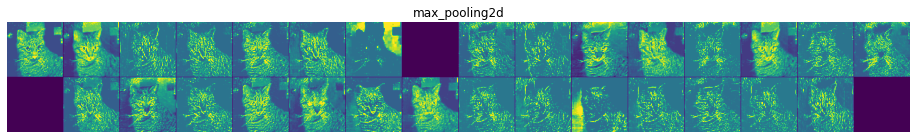

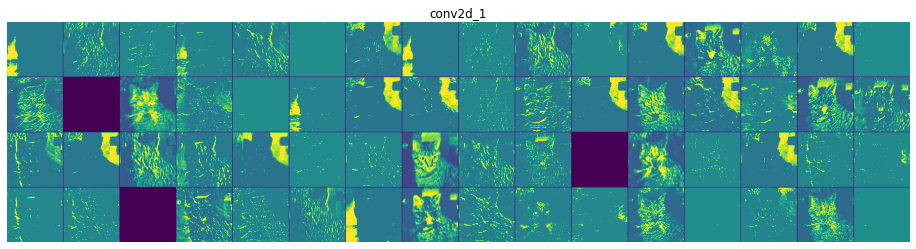

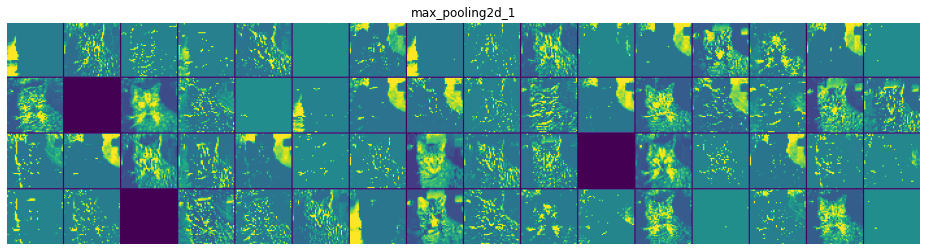

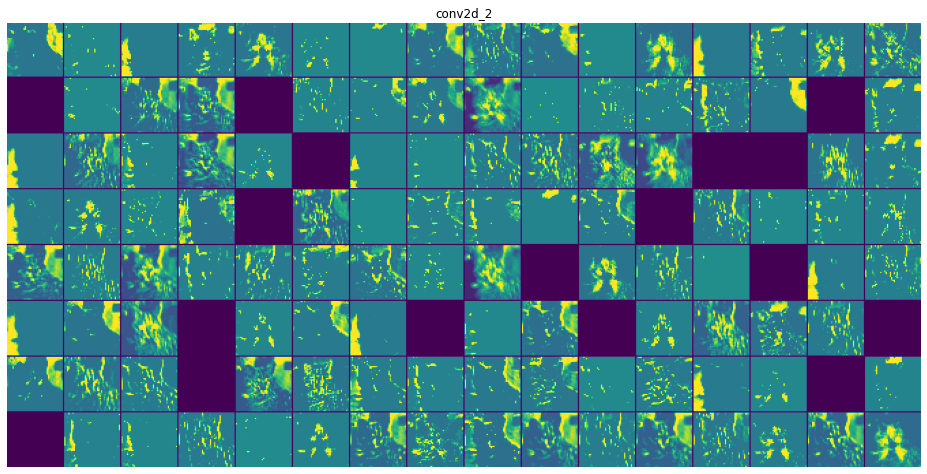

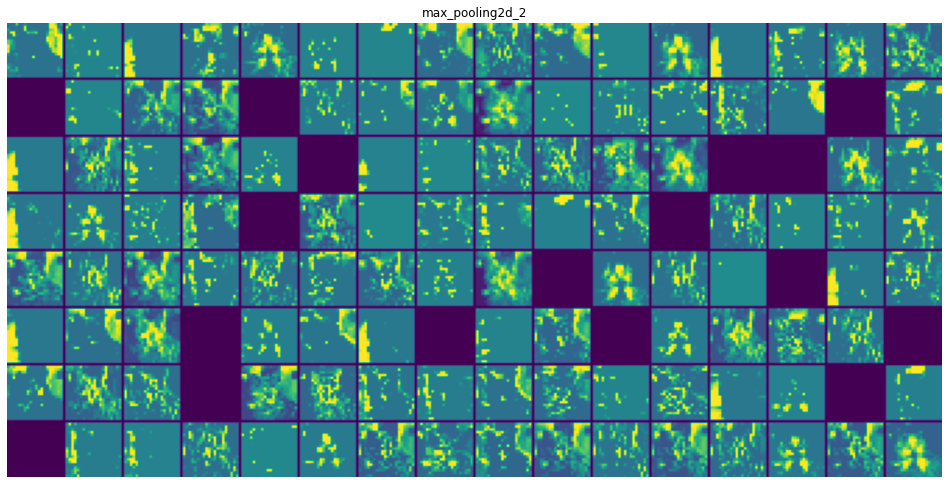

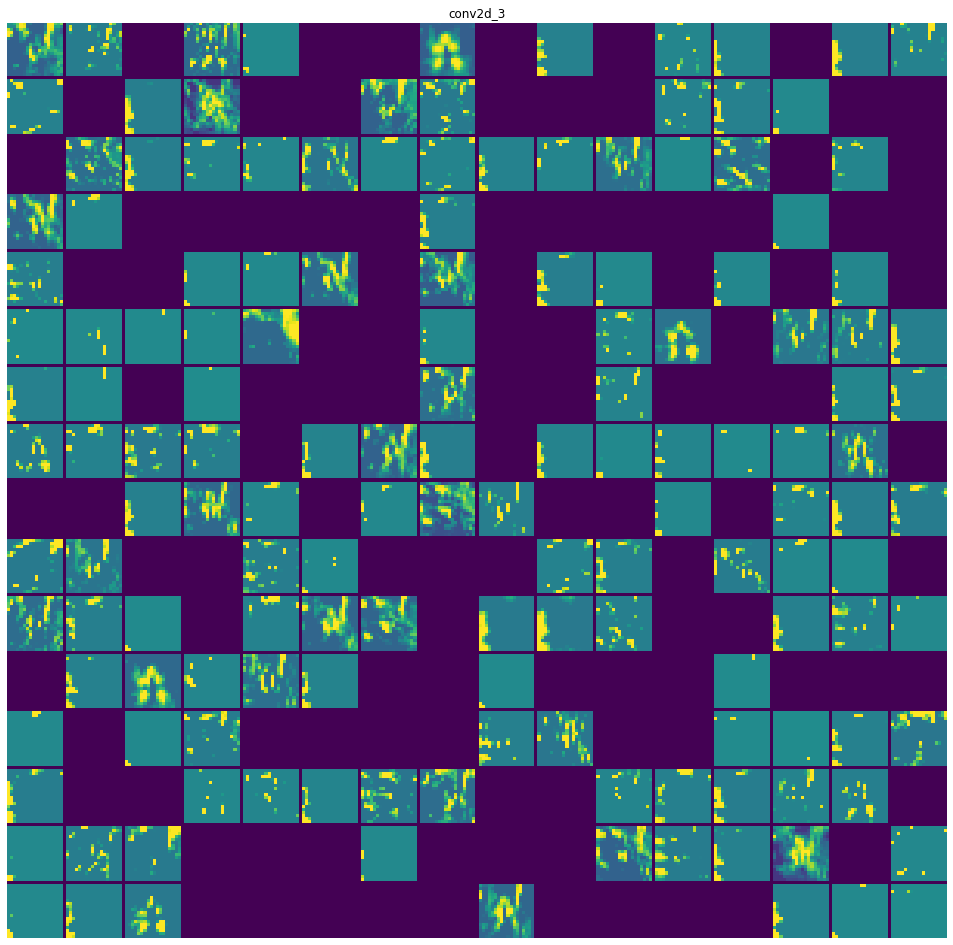

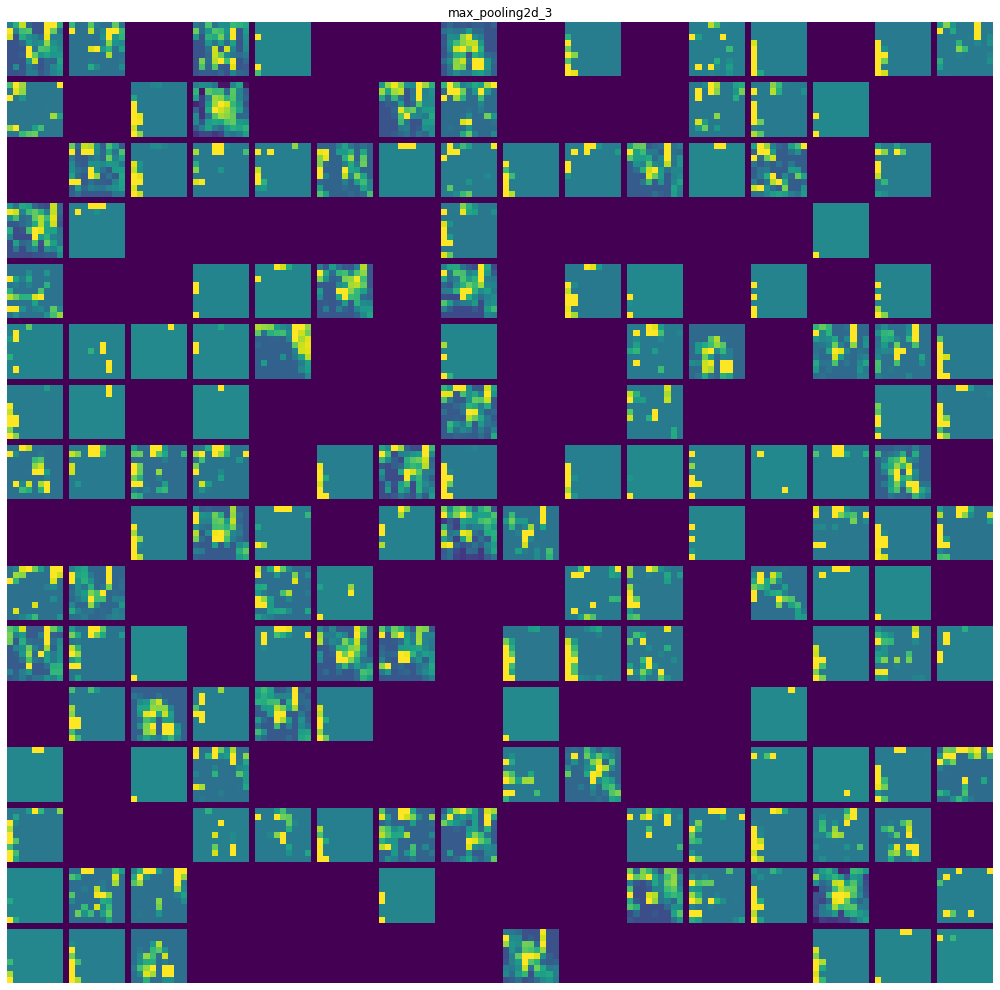

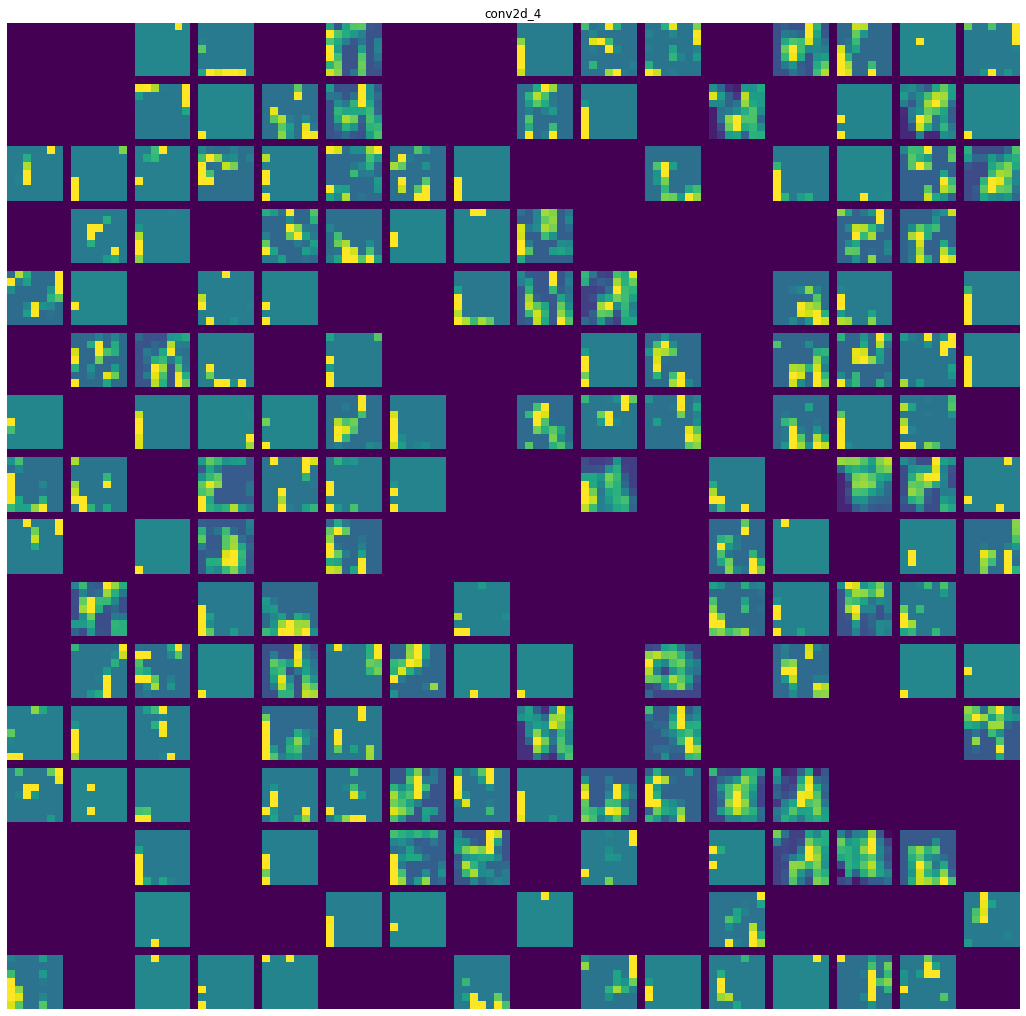

In [44]:
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros(((size + 1) * n_cols - 1,
                             images_per_row * (size + 1) - 1))
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_index = col * images_per_row + row
            channel_image = layer_activation[0, :, :, channel_index].copy()
            if channel_image.sum() != 0:
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype("uint8")
            display_grid[
                col * (size + 1): (col + 1) * size + col,
                row * (size + 1) : (row + 1) * size + row] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.axis("off")
    plt.imshow(display_grid, aspect="auto", cmap="viridis")

We note that the deeper the layer is more abstract the layer is. The sparsity also increases due to the fact that the patterns encoded by filters are not found in the images.

**Visualizing convets filters :**